In [311]:
from manifold_learning import IMD
import numpy as np
from FastCCM import CCM
from manifold_learning.utils import utils
from manifold_learning.data.data_loader import get_truncated_lorenz_rand,load_csv_dataset,load_traffic_dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from manifold_learning import imd_nd_smap, imd_1d_smap
import importlib
importlib.reload(imd_nd_smap)
importlib.reload(imd_1d_smap)

<module 'manifold_learning.imd_1d_smap' from '/home/iaroslav/Documents/Python projects/manifold_learning/src/manifold_learning/imd_1d_smap.py'>

In [278]:
X = observables
n, d = X.shape
m = 50
tp = 20

z_X = X[:-tp]
z_y = X[tp:]
c = np.argsort(np.random.rand(n-tp))[:m]

dist = pairwise_distances(X[c], z_X)
w = np.exp(-dist/dist.mean(axis=1)[:,None])

XX = (w[:,:,None] * z_X[None].repeat(m,0)).reshape(m, (n - tp), d)
XX = np.transpose(XX,(1,0,2)).reshape(-1,m*d)
yy = (w[:,:,None] * z_y[None].repeat(m,0)).reshape(m, (n - tp), d)
yy = np.transpose(yy,(1,0,2)).reshape(-1,m*d)

B = (np.linalg.inv(XX.T @ XX) @ XX.T @ yy)

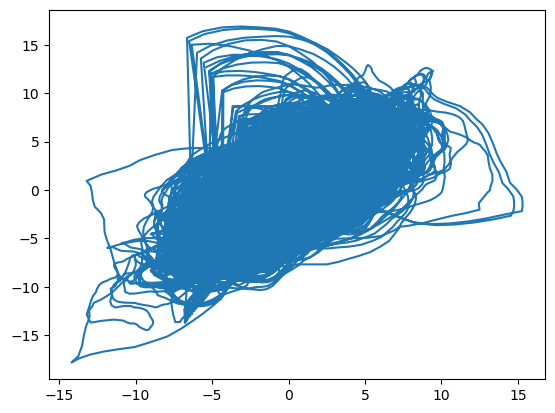

In [198]:
plt.plot(XX[:,2], yy[:,2])

In [2075]:
# Load traffic dataset
X = load_traffic_dataset()
page_names = X["Page"].to_numpy().astype("str")
X = X[X.columns[1:]]

df = X.T

# Interpolate missing values
df_interpolated = df.interpolate(method='linear', limit_direction='forward', axis=0)

# Fill any remaining missing values with zeros
df_filled = df_interpolated.fillna(0)
X = df_filled.to_numpy().astype(np.float32)


X = np.log(X+1)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
page_names = page_names[X.mean(axis=0) != 0]
X = X[:,X.mean(axis=0) != 0]
X = (X-X.mean(axis=0))/X.std(axis=0)

mask = (np.count_nonzero(np.diff(X[:,:],axis=0),axis=0) > 750)
X = X[:,mask]
page_names = page_names[mask]
observables = StandardScaler().fit_transform(X)

In [288]:
def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y,axis=1)**2 / (2 * sigma**2))

In [285]:
X = get_truncated_lorenz_rand(400,n_steps=20000)

In [217]:
X = load_csv_dataset("Jan1023_1_fr_ma2sec_sr30.csv").to_numpy()[:,1:]
#X = utils.get_td_embedding_np(X,5,20).reshape(-1,5*X.shape[1])

observables = StandardScaler().fit_transform(X)

In [286]:
exp_kernel_grid = np.array(np.meshgrid(np.linspace(X[:,0].min(),X[:,0].max(),6), np.linspace(X[:,2].min(),X[:,2].max(),6))).reshape(2,-1).T

In [289]:
X_ = [get_truncated_lorenz_rand(400,n_steps=20000)[:,[0,2]] for i in range(5)]
observables = np.concatenate([np.array([gaussian_kernel(x,e,sigma=15) for e in exp_kernel_grid]) for x in X_]).T

observables = StandardScaler().fit_transform(observables)

In [2197]:
observables = observables @ np.random.normal(0,1,(180,180))

In [250]:
trainer = imd_nd_smap.IMD_nD_smap(observables.shape[1], embed_dim=3, n_components=1, subtract_corr=True, device="cuda")


In [313]:
trainer = imd_1d_smap.IMD_1D_smap(observables.shape[1], embed_dim=3, embed_lag=10, n_components=5, subtract_corr=True, device="cuda")



In [322]:
trainer.compute_loss_only(observables, sample_len=80, library_len=800, 
            exclusion_rad=90, theta=5, tp=30, 
             num_batches=32, tp_policy="range")


1.0629797708243132

In [305]:
trainer.fit(observables, sample_len=80, library_len=800, 
            exclusion_rad=90, theta=5, tp=30, 
            epochs=1000, num_batches=32, optimizer="Adagrad", learning_rate=0.02, tp_policy="range")


Epoch 1/1000, Loss: 0.6547
Epoch 2/1000, Loss: 0.6513
Epoch 3/1000, Loss: 0.6690
Epoch 4/1000, Loss: 0.6594
Epoch 5/1000, Loss: 0.6627
Epoch 6/1000, Loss: 0.6722
Epoch 7/1000, Loss: 0.6614
Epoch 8/1000, Loss: 0.6621
Epoch 9/1000, Loss: 0.6496
Epoch 10/1000, Loss: 0.6594
Epoch 11/1000, Loss: 0.6628
Epoch 12/1000, Loss: 0.6588
Epoch 13/1000, Loss: 0.6624
Epoch 14/1000, Loss: 0.6640
Epoch 15/1000, Loss: 0.6507
Epoch 16/1000, Loss: 0.6540
Epoch 17/1000, Loss: 0.6594
Epoch 18/1000, Loss: 0.6581
Epoch 19/1000, Loss: 0.6610
Epoch 20/1000, Loss: 0.6550
Epoch 21/1000, Loss: 0.6624
Epoch 22/1000, Loss: 0.6538
Epoch 23/1000, Loss: 0.6623
Epoch 24/1000, Loss: 0.6555
Epoch 25/1000, Loss: 0.6632
Epoch 26/1000, Loss: 0.6622
Epoch 27/1000, Loss: 0.6626
Epoch 28/1000, Loss: 0.6632
Epoch 29/1000, Loss: 0.6603
Epoch 30/1000, Loss: 0.6637
Epoch 31/1000, Loss: 0.6661
Epoch 32/1000, Loss: 0.6636
Epoch 33/1000, Loss: 0.6628
Epoch 34/1000, Loss: 0.6590
Epoch 35/1000, Loss: 0.6528
Epoch 36/1000, Loss: 0.6570
E

KeyboardInterrupt: 

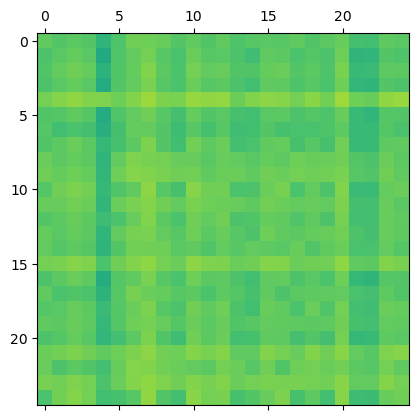

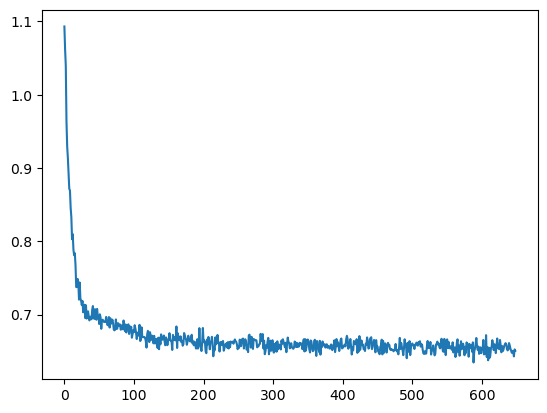

In [306]:
plt.plot(trainer.get_loss_history()[:])


In [307]:

unmixed = trainer.predict(observables)

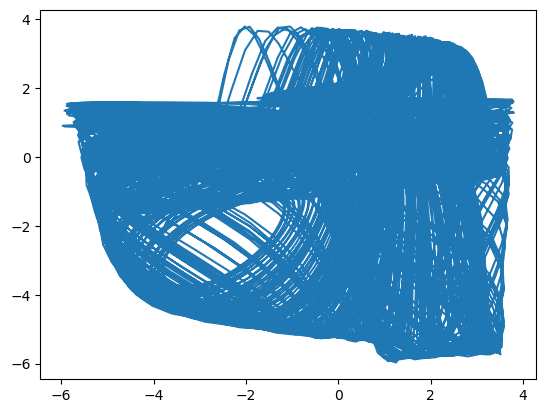

In [308]:
plt.plot(unmixed[30:,0,0],unmixed[:-30,0,0])

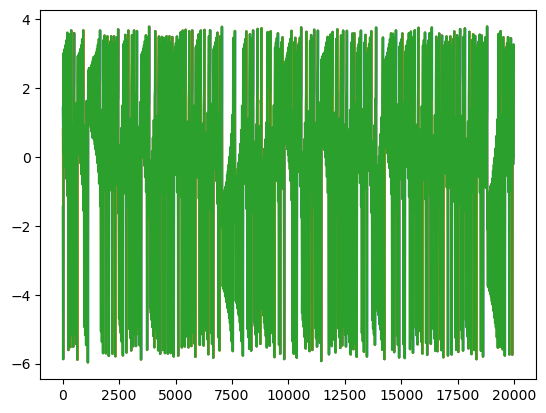

In [309]:

plt.plot(unmixed[:,0,:])
#plt.xlim(0,2000)

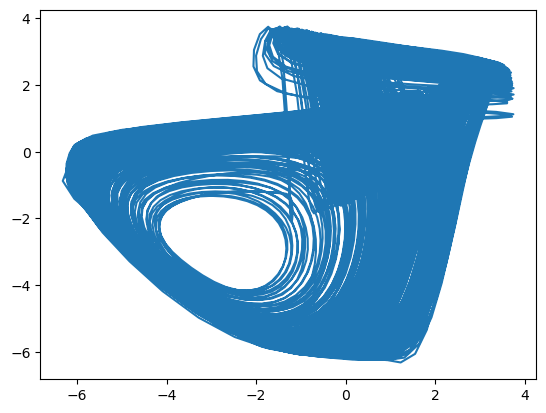

In [300]:
plt.plot(unmixed[:,0,1], unmixed[:,0,0])

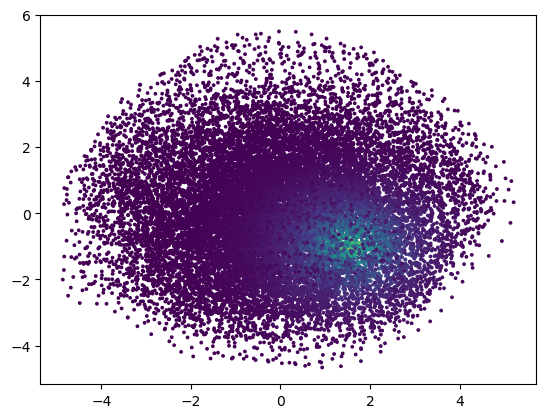

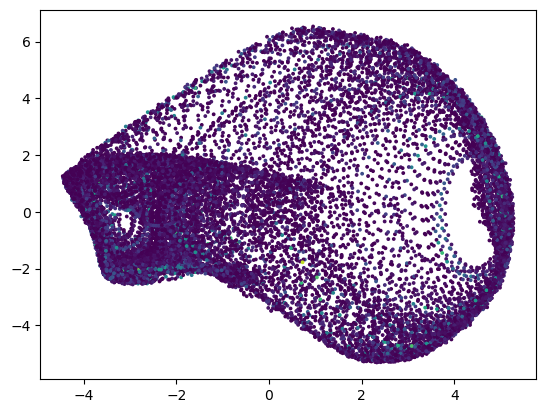

In [301]:
from sklearn.metrics import pairwise_distances

dist = pairwise_distances(unmixed[:,1][[3150]],unmixed[:,1])[0]
weights = np.exp(-(4*dist/dist.mean()))

x_pca = PCA(2).fit_transform(unmixed[:,1,:])
plt.scatter(x_pca[:-20,0],x_pca[:-20,1],c=weights[:-20],s=3)
plt.show()

x_pca = PCA(2).fit_transform(unmixed[:,0,:])
plt.scatter(x_pca[20:,0],x_pca[20:,1],c=weights[:-20],s=3)

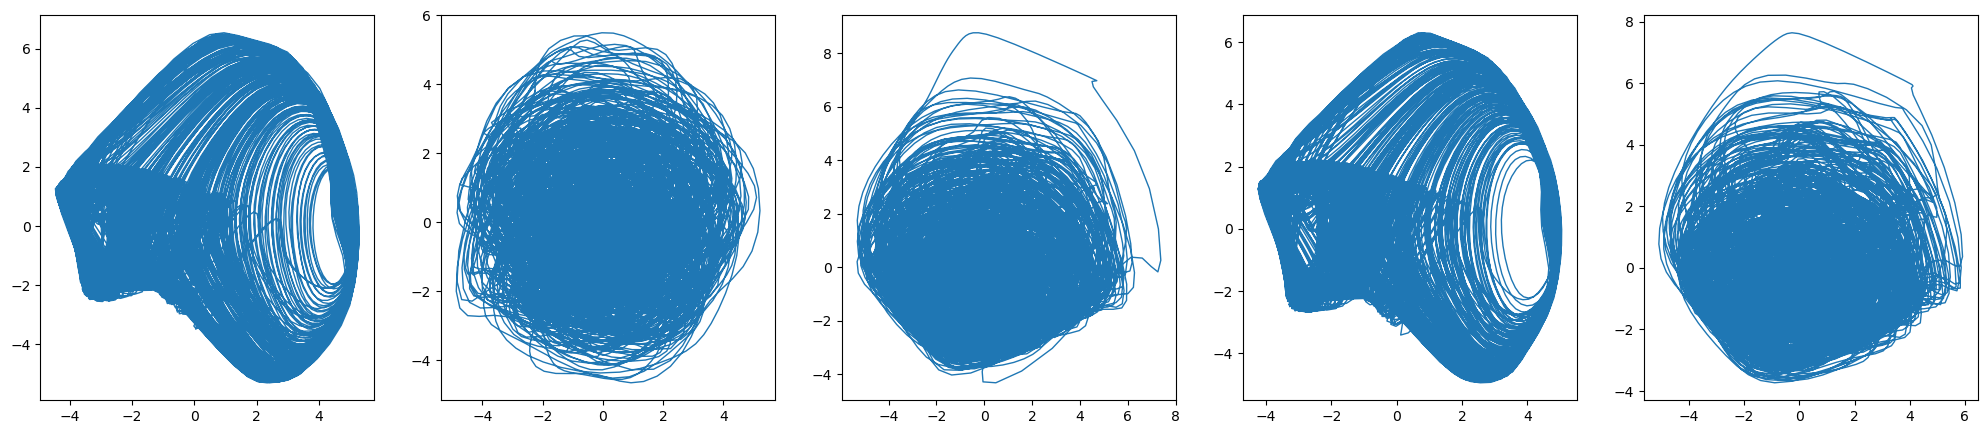

In [302]:
plt.figure(figsize=(5*unmixed.shape[1],5))
for i in range(unmixed.shape[1]):
    plt.subplot(1,unmixed.shape[1],i+1)
    x_pca = PCA(2).fit_transform(unmixed[:,i,:])
    plt.plot(x_pca[:,0],x_pca[:,1],linewidth=1)

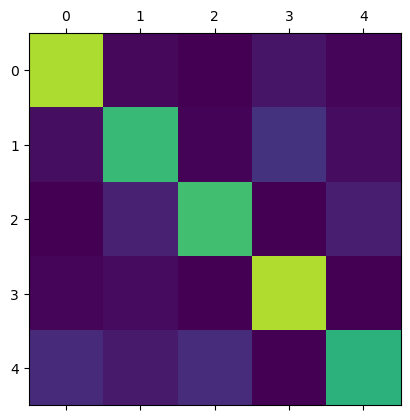

In [303]:
plt.matshow(CCM.PairwiseCCM().compute(np.transpose(unmixed,axes=(1,0,2)),np.transpose(unmixed,axes=(1,0,2)),1500,400,60,30,30,False).mean(axis=0),vmin=0,vmax=1)

In [304]:
import plotly.express as px
x_pca = PCA(3).fit_transform(unmixed[:,0,:])
fig = px.line_3d(x=x_pca[:,0], y=x_pca[:,1],z=x_pca[:,2],height=700)

fig.show()

In [238]:
fig = px.line_3d(x=unmixed[:,0,0], y=unmixed[:,0,1],z=unmixed[:,0,2],height=700)

fig.show()

Epoch 1/300, Loss: 1.2828
Epoch 2/300, Loss: 1.2530
Epoch 3/300, Loss: 1.1501
Epoch 4/300, Loss: 1.1606
Epoch 5/300, Loss: 1.1323
Epoch 6/300, Loss: 1.1020
Epoch 7/300, Loss: 1.0887
Epoch 8/300, Loss: 1.0842
Epoch 9/300, Loss: 1.0769
Epoch 10/300, Loss: 1.0608
Epoch 11/300, Loss: 1.0580
Epoch 12/300, Loss: 1.0484
Epoch 13/300, Loss: 1.0543
Epoch 14/300, Loss: 1.0623
Epoch 15/300, Loss: 1.0369
Epoch 16/300, Loss: 1.0216
Epoch 17/300, Loss: 1.0198
Epoch 18/300, Loss: 1.0081
Epoch 19/300, Loss: 1.0137
Epoch 20/300, Loss: 1.0189
Epoch 21/300, Loss: 1.0019
Epoch 22/300, Loss: 1.0064
Epoch 23/300, Loss: 0.9976
Epoch 24/300, Loss: 0.9989
Epoch 25/300, Loss: 0.9920
Epoch 26/300, Loss: 0.9833
Epoch 27/300, Loss: 0.9777
Epoch 28/300, Loss: 0.9802
Epoch 29/300, Loss: 0.9797
Epoch 30/300, Loss: 0.9781
Epoch 31/300, Loss: 0.9807
Epoch 32/300, Loss: 0.9681
Epoch 33/300, Loss: 0.9594
Epoch 34/300, Loss: 0.9627
Epoch 35/300, Loss: 0.9636
Epoch 36/300, Loss: 0.9612
Epoch 37/300, Loss: 0.9641
Epoch 38/3

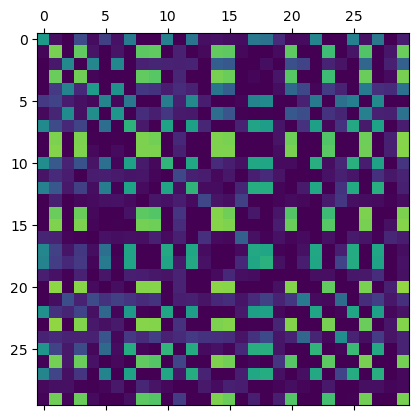

In [145]:
vars = []
for j in range(10):
    trainer = imd_nd_smap.IMD_nD_smap(observables.shape[1], embed_dim=3, n_components=3, subtract_corr=True, device="cuda")
    trainer.fit(observables, sample_len=80, library_len=800, 
            exclusion_rad=90, theta=4, tp=90, 
            epochs=300, num_batches=32, optimizer="Adagrad", learning_rate=0.02, tp_policy="range")

    unmixed = trainer.predict(observables)
    vars += [np.transpose(unmixed,(1,0,2))]
vars = np.concatenate(vars)
plt.matshow(CCM.PairwiseCCM().compute(vars,vars,1500,400,60,30,90,False).mean(axis=0),vmin=0,vmax=1)

13.0